# Short Intro to Weighted Cross-Validation

#### This kernel is introducing a weighted approach to Cross-validation which oddly I don't see many kagglers using or maybe revealing.
#### Formulation:    
                                    Weighted Test predictions using information from the Kfold validation results
                    
$\textbf{v} = MinMax\;(\;vector \; of max \; validation\; scores\; per\; fold\;)$ range = [min=0,max=1] <br> 
$\textbf{p} = matrix \;(\;n\_folds,\; n\_predictions\;)$
$\textbf{R} =  \frac{1}{n\_folds} \sum_i (\textbf{v}  \circ  \textbf{p})_i$
------------------------------------------------------------------------
###### Feel free to upvote,fork and test using  your own datasets :D , <br>




In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.axes_style("darkgrid")
from sklearn.model_selection import KFold,StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import  train_test_split
import warnings
warnings.filterwarnings('ignore')

- 
For the sake of just introducting the approach we will be using a fast lgbm model with a sample from the dataset

In [2]:
%time
df_t = pd.read_csv('../input/train.csv')
df_tst = pd.read_csv('../input/test.csv')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.44 µs


In [3]:
frac_sample =1
df_train = df_t.copy().sample(frac=(frac_sample))
df_test = df_tst.copy().sample(frac=(frac_sample))
X = df_train.iloc[:,2:]
y = df_train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)
print('Train : ' , X_train.shape)
print('Test : ' , X_test.shape)

Train :  (140000, 200)
Test :  (60000, 200)


# LGBM Model

In [4]:
#Model LGBM 
param = {
    'bagging_freq': 8, #handling overfitting
    'bagging_fraction': 0.4, #handling overfitting - adding some noise
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.4, #handling overfitting
    'learning_rate': 0.01, #the changes between one auc and a better one gets really small thus a small learning rate performs better
    'max_depth': 2,  #smaller trees less overfitting
    'metric':'auc',
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 0
    }

lgbm_X = X_train
lgbm_y = y_train
lgbm_test_x = X_test
lgbm_test_y = y_test
val_pred = []
importand_folds = np.zeros(lgbm_X.shape[1])
test_pred_lgbm = []
target_pred = []
kf = KFold(n_splits=20,random_state=21)
for _fold, (trn_idx, val_idx) in enumerate(kf.split(lgbm_X.values, lgbm_y.values)):
            Xtrn, ytrn = lgbm_X.iloc[trn_idx], lgbm_y.iloc[trn_idx]
            Xval, y_val = lgbm_X.iloc[val_idx], lgbm_y.iloc[val_idx]
            #-----------------------------------------
            print('Fold: ', _fold)
            dtrain = lgb.Dataset(Xtrn,label=ytrn)
            dval = lgb.Dataset(Xval,label=y_val)
            clf = lgb.train(param,dtrain,num_boost_round=5000,valid_sets=(dtrain,dval),valid_names=['train','valid'],
                      verbose_eval=500,
                     early_stopping_rounds=250)
            #----------------------------------------
            importand_folds += clf.feature_importance()
            #validation score
            val_pred.append(clf.best_score['valid']['auc'])
            #save the test prediction per fold
            test_pred_lgbm.append(clf.predict(lgbm_test_x))
            print('-'*50)
            target_pred.append(clf.predict(df_test.iloc[:,1:]))

Fold:  0
Training until validation scores don't improve for 250 rounds.
[500]	train's auc: 0.798819	valid's auc: 0.79089
[1000]	train's auc: 0.83979	valid's auc: 0.828445
[1500]	train's auc: 0.860954	valid's auc: 0.845719
[2000]	train's auc: 0.874323	valid's auc: 0.857947
[2500]	train's auc: 0.883551	valid's auc: 0.867
[3000]	train's auc: 0.890729	valid's auc: 0.873683
[3500]	train's auc: 0.896106	valid's auc: 0.878751
[4000]	train's auc: 0.900458	valid's auc: 0.882316
[4500]	train's auc: 0.904035	valid's auc: 0.885141
[5000]	train's auc: 0.907362	valid's auc: 0.887884
Did not meet early stopping. Best iteration is:
[5000]	train's auc: 0.907362	valid's auc: 0.887884
--------------------------------------------------
Fold:  1
Training until validation scores don't improve for 250 rounds.
[500]	train's auc: 0.797144	valid's auc: 0.800405
[1000]	train's auc: 0.838729	valid's auc: 0.837928
[1500]	train's auc: 0.860015	valid's auc: 0.856072
[2000]	train's auc: 0.87374	valid's auc: 0.866702


In [5]:
from sklearn.preprocessing import MinMaxScaler 
def weight_pred(preds,vals,n_splits,range_features =(0.9,1) ):
    ## Setting Up predictions dataframe
    df_pred = pd.DataFrame(preds)
    df_pred.columns = ['pred_'+str(x) for x in range(df_pred.shape[1])]
    
    
    #Min Max scaling for the max fold validation values
    #the feature range plays the role of a hyper-parameter to balance the effect of the validation set on the test set
    scaler = MinMaxScaler(feature_range=range_features).fit(np.array([vals]).T)
    val_scaled = scaler.transform(np.array([vals]))
    
    #multiply scaled values by  each row in the dataframe which represent a fold
    df_scaled = df_pred.mul(val_scaled.tolist()[0],axis=0)
    
    #sum and divide
    df_pred_final = df_pred.sum(axis=0) / n_splits
    df_scaled_final = df_scaled.sum(axis=0) / n_splits
    return df_pred,df_scaled,df_pred_final,df_scaled_final

In [6]:
#testing predictions
df_pred,df_scaled,df_pred_final,df_scaled_final = weight_pred(test_pred_lgbm,val_pred,kf.n_splits)

#target predictions
_1,_2,df_test_pred_final,df_test_scaled_final = weight_pred(target_pred,val_pred,kf.n_splits)

# Predictions DistPlot Comparison

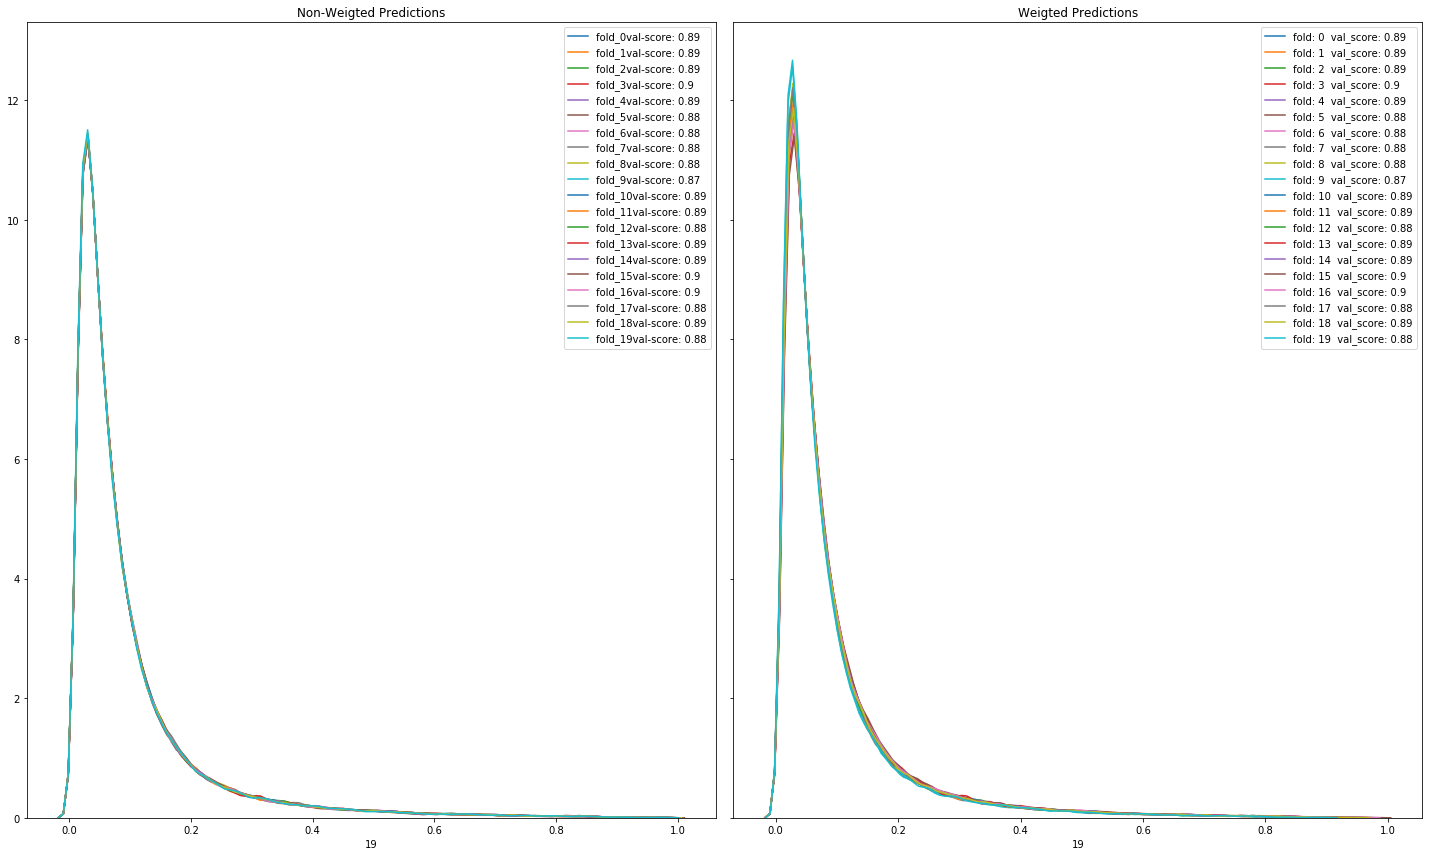

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(20,12))
for fold in range(df_pred.shape[0]):
    sns.distplot(df_pred.iloc[fold],label='fold_'+str(fold) + 'val-score: {:.2}'.format(val_pred[fold]),ax=ax1, hist=False)
    sns.distplot(df_scaled.iloc[fold],label='fold: '+str(fold) + '  val_score: {:.2}'.format(val_pred[fold]),ax=ax2,hist=False)
ax1.set_title('Non-Weigted Predictions')
ax2.set_title('Weigted Predictions')
plt.tight_layout()
plt.legend()
plt.show()

We can see the extra noise the weighting applies in the right plot

# Evaluation

The Evaluation should be run on multiple prediction samples, but this is an intro so I'm excused :D

Or.....you can try it yourself.....that also works :D

In [8]:
#Scores
normal_score = roc_auc_score(y_test,df_pred_final.values)
weighted_score = roc_auc_score(y_test,df_scaled_final.values)
print('Test Scores')
print('-'*50)
print('Normal Score :   {:.10}'.format(normal_score))
print('Weighted Score : {:.10}'.format(weighted_score))

Test Scores
--------------------------------------------------
Normal Score :   0.8852303497
Weighted Score : 0.8852321607


In [9]:
#let check the test scores difference depending on the range given
rng  = [(0.5,1),(0.6,1),(0.7,1),(0.8,1),(0.9,1),(0.5,0.8),(0.6,0.8),(0.2,0.8)]
wt_scores = []
non_wt_scores =  []
for r in rng:
    df_pred,df_scaled,df_pred_final,df_scaled_final = weight_pred(test_pred_lgbm,val_pred,kf.n_splits,range_features = r)
    non_wt_scores.append(roc_auc_score(y_test,df_pred_final.values))
    wt_scores.append(roc_auc_score(y_test,df_scaled_final.values))

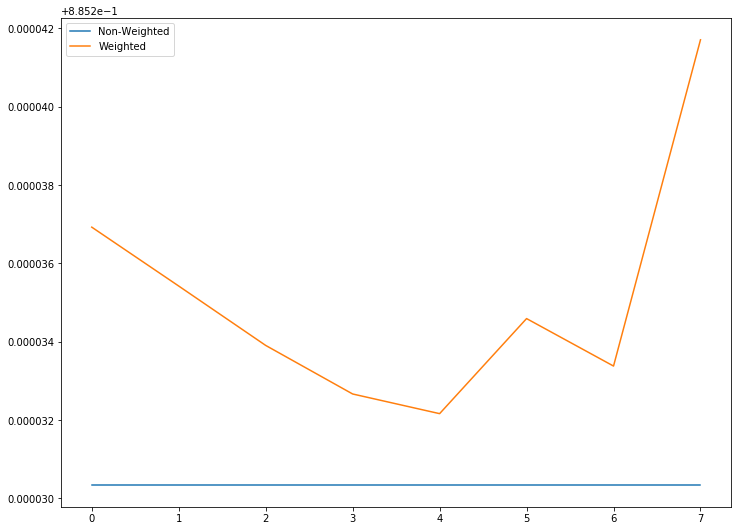

In [10]:
plt.figure(figsize=(12,9))
sns.lineplot(x=range(len(non_wt_scores)),y=non_wt_scores,label='Non-Weighted')
sns.lineplot(x=range(len(wt_scores)),y=wt_scores,label='Weighted')
plt.legend()
plt.show()

This can also prove to have better performance when dealing with a larger distributed range for predictions, and that's why we can see only a minor improvement regarding the prediction for this dataset. 

Thank you ! Any Feedback Appreciated 

In [11]:
def sub_pred(preds,df_test,name='submission.csv'):
    sub_df = pd.DataFrame({'ID_code':df_test['ID_code'],'target':preds})
    sub_df.to_csv(name, index=False)

    
sub_file = 'scaled_pred.csv'
sub_pred(df_test_scaled_final.values,df_test,name=sub_file)
print(sub_file+'-submitted successfully')

sub_file = 'non_scaled_pred.csv'
sub_pred(df_test_pred_final.values,df_test,name=sub_file)
print(sub_file+'-submitted successfully')

scaled_pred.csv-submitted successfully
non_scaled_pred.csv-submitted successfully
